In [1]:
%load_ext lab_black

In [2]:
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import models.seg as sm
from Data import Data_train, Data_eval
from include.loss import pixel_weighted_cross_entropy
from saver import Saver
from include.generators import Generator

import model_eval
import wandb
from wandb.keras import WandbCallback

2023-02-07 15:25:05.033770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/cerea_raid/users/dumontj/dev/coco2/dl


### Data download

In [3]:
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip/2d_train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/2d_valid_dataset.nc"
path_eval_nc = path_valid_nc

save_dir = "/cerea_raid/users/dumontj/dev/coco2/dl/nb_train/sim/test"

In [4]:
chan_1 = "xco2"
chan_2 = "no2"
chan_3 = "u_wind"
chan_4 = "v_wind"

In [5]:
data = Data_eval(path_eval_nc)
data.prepare_input(model_eval.get_scaler(save_dir), chan_1, chan_2, chan_3, chan_4)
data.prepare_output_segmentation(max_w=1)
model = model_eval.get_segmentation_model(os.path.join(save_dir), name_w="best_w.h5")

data.x.eval.shape (1152, 64, 64, 4)
data.y.train.shape (1152, 64, 64, 1)


2023-02-07 15:25:12.685156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 15:25:13.198898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14516 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


## cv2

In [6]:
from sklearn.preprocessing import StandardScaler
import cv2

In [7]:
x = tf.convert_to_tensor(data.x.eval, np.float32)
pred = tf.convert_to_tensor(model.predict(x), np.float32)

2023-02-07 15:25:19.533146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-02-07 15:25:20.092921: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


36/36 [==============================] - 4s 14ms/step


In [25]:
idx = int(np.random.uniform(0, data.x.eval.shape[0]))
X = np.squeeze(pred[idx].numpy())
X = X > 0.4
arr = X.copy()

x1 = np.repeat(np.arange(X.shape[0]), len(X.flatten()) / len(np.arange(X.shape[0])))
x2 = np.tile(np.arange(X.shape[1]), int(len(X.flatten()) / len(np.arange(X.shape[1]))))
x3 = X.flatten()

# X = np.array([x1, x2, x3]).T
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

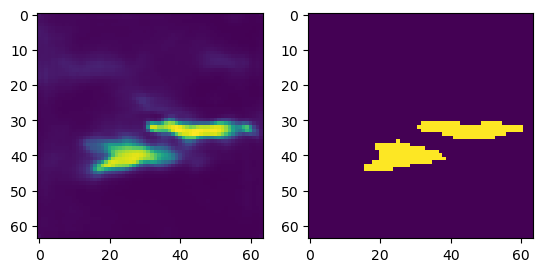

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.squeeze(pred[idx].numpy()))
ax2.imshow(arr)
plt.show()

In [27]:
r_centre = 3

In [28]:
img = np.array(arr, dtype=np.uint8)
img[
    int(img.shape[0] / 2 - r_centre) : int(img.shape[0] / 2 + r_centre),
    int(img.shape[1] / 2 - r_centre) : int(img.shape[1] / 2 + r_centre),
] = 1

num_labels, labels_im = cv2.connectedComponents(img)

In [29]:
labels_im[labels_im != labels_im[int(img.shape[0] / 2), int(img.shape[1] / 2)]] = 0

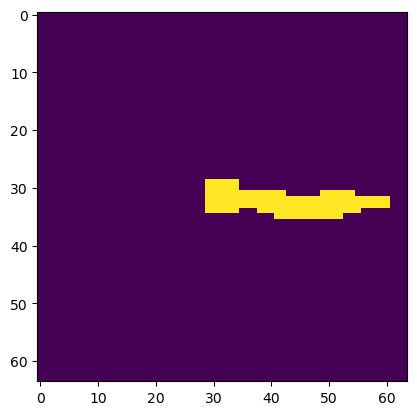

In [30]:
plt.imshow(labels_im)